# Decomposoitions and Plots

In [1]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 19 20:46:48 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             52W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# Import google drive mounting module
from google.colab import drive

# Import os/path lib to navigate the colab directory.
import os
import pathlib


# Mount Google Drive at the default location
drive.mount('/content/drive', force_remount=False)
# Define the path to your desired folder
path = '/content/drive/My Drive/OPM-MEG'
# Change to that directory
os.chdir(path)
# Verify the current working directory
print("Current Directory:", os.getcwd())

Mounted at /content/drive
Current Directory: /content/drive/My Drive/OPM-MEG


In [4]:
!git clone https://github.com/hug0-w/Tensor-Decompositions-OPM-MEG/
!pip install tensorly

fatal: destination path 'Tensor-Decompositions-OPM-MEG' already exists and is not an empty directory.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.7 MB/s eta 0:00:00


In [5]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 14.2 MB/s eta 0:00:00


In [6]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 121.9 MB/s eta 0:00:00


# Outcome

Loading Outcome_TFR_ROI_Data_Fixed.mat...
Decoding Data ROI labels...
Decoding Atlas labels...

Target: Trial 1 | 10.0 Hz | 0.500 s
Mapping data to AAL2 NIfTI volume...
--- Summary ---
ROIs Mapped: 114
ROIs Missing: 0
Generating Glass Brain Plot...


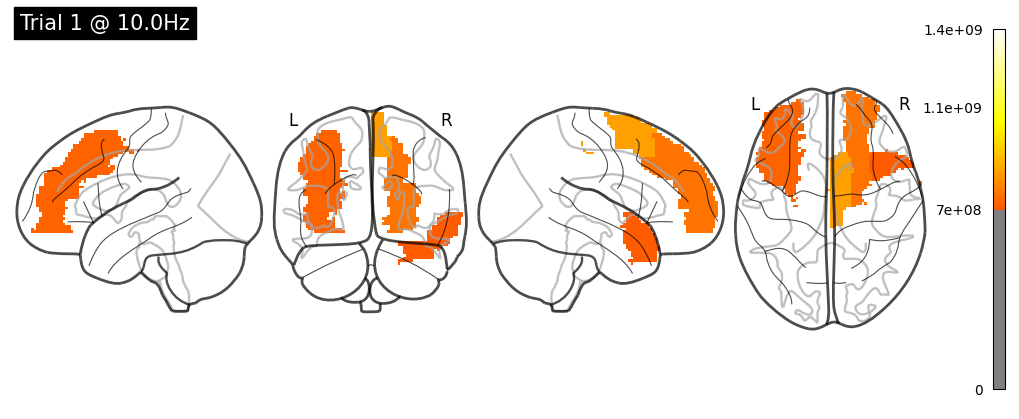

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting

# ==========================================
# 1. CONFIGURATION
# ==========================================
MAT_FILE_PATH  = r'Outcome_TFR_ROI_Data_Fixed.mat'  # Your MATLAB output from Step 8
ATLAS_NII_PATH = r'aal2.nii' # Path to your AAL2 NIfTI file

# Plot Settings
PLOT_TRIAL_IDX = 0     # Index of the trial to plot (0 = First Trial)
PLOT_FREQ_HZ   = 10    # Frequency in Hz (e.g., 10 for Alpha)
PLOT_TIME_SEC  = 0.5   # Time in seconds

# ==========================================
# 2. HELPER FUNCTION: MATLAB STRING DECODING
# ==========================================
def get_matlab_strings(f, dataset_path):
    """
    Robustly extracts a cell array of strings from a MATLAB v7.3 HDF5 file.
    Handles object references and various encoding issues.
    """
    if dataset_path not in f:
        return None

    ref_array = f[dataset_path][:]
    ref_array = ref_array.flatten()

    strings = []
    for ref in ref_array:
        try:
            # Dereference the object
            char_obj = f[ref]
            # Read integer array and convert to string
            chars = char_obj[:].flatten()
            str_val = ''.join([chr(c) for c in chars])
            strings.append(str_val)
        except Exception as e:
            # Fallback for empty or malformed strings
            strings.append("UNKNOWN")

    return strings

# ==========================================
# 3. LOAD DATA
# ==========================================
print(f"Loading {MAT_FILE_PATH}...")

with h5py.File(MAT_FILE_PATH, 'r') as f:

    # --- A. Load 4D Tensor ---
    # H5PY reads as [Time, Freq, ROI, Trials]. We transpose to [Trials, ROIs, Freq, Time]
    if 'tensor' in f:
        raw_tensor = f['tensor'][:]
        # Transpose: (3, 2, 1, 0)
        power_data = raw_tensor.transpose(3, 2, 1, 0)
    else:
        # Fallback if variable is named differently (e.g. inside TFR_4D)
        print("Variable 'tensor' not found. Trying 'TFR_4D/powspctrm'...")
        raw_tensor = f['TFR_4D']['powspctrm'][:]
        power_data = raw_tensor.transpose(3, 2, 1, 0)

    # --- B. Load Axes ---
    time_axis = f['TFR_4D']['time'][:].flatten()
    freq_axis = f['TFR_4D']['freq'][:].flatten()

    # --- C. Load ROI Labels (from Data) ---
    print("Decoding Data ROI labels...")
    roi_labels = get_matlab_strings(f, 'TFR_4D/label')

    # --- D. Load Atlas Labels (from Atlas Structure) ---
    print("Decoding Atlas labels...")
    if 'atlas' in f:
        # Try standard FieldTrip name first, then fallback
        if 'tissuelabel' in f['atlas']:
            full_atlas_labels = get_matlab_strings(f, 'atlas/tissuelabel')
        elif 'label' in f['atlas']:
            full_atlas_labels = get_matlab_strings(f, 'atlas/label')
        else:
            raise KeyError("Found 'atlas' struct but no 'tissuelabel' or 'label' field.")
    else:
        raise KeyError(f"'atlas' variable missing from {MAT_FILE_PATH}. Re-save in MATLAB.")

# ==========================================
# 4. DATA EXTRACTION & NAN HANDLING
# ==========================================
# Find indices
freq_idx = np.abs(freq_axis - PLOT_FREQ_HZ).argmin()
time_idx = np.abs(time_axis - PLOT_TIME_SEC).argmin()
actual_freq = freq_axis[freq_idx]
actual_time = time_axis[time_idx]

print(f"\nTarget: Trial {PLOT_TRIAL_IDX+1} | {actual_freq:.1f} Hz | {actual_time:.3f} s")

# Extract Power Vector [nROIs]
roi_power_values = power_data[PLOT_TRIAL_IDX, :, freq_idx, time_idx]

# Handle NaNs: Replace with 0.0 so the code doesn't crash
if np.isnan(roi_power_values).any():
    nan_count = np.sum(np.isnan(roi_power_values))
    print(f"Warning: Found {nan_count} NaNs in data. Replacing with 0.0.")
    roi_power_values = np.nan_to_num(roi_power_values, nan=0.0)

# ==========================================
# 5. MAPPING TO NIFTI VOLUME
# ==========================================
print("Mapping data to AAL2 NIfTI volume...")

# Load Atlas
aal_img = nib.load(ATLAS_NII_PATH)
aal_data = aal_img.get_fdata()
affine = aal_img.affine

# Create empty brain volume
power_map_3d = np.zeros(aal_data.shape)

mapped_count = 0
missing_count = 0

for i, roi_name in enumerate(roi_labels):
    val = roi_power_values[i]

    # Optimization: Don't paint zeros
    if val == 0:
        continue

    try:
        # 1. Find the integer ID of this ROI in the Atlas List
        # Python .index() finds the position. NIfTI ID is usually Position + 1.
        atlas_list_idx = full_atlas_labels.index(roi_name)
        atlas_id = atlas_list_idx + 1

        # 2. Paint the voxels
        mask = (aal_data == atlas_id)
        if np.any(mask):
            power_map_3d[mask] = val
            mapped_count += 1

    except ValueError:
        # ROI name from data not found in atlas list
        missing_count += 1
        if missing_count <= 3: # Print first few errors only
            print(f"  Warning: ROI '{roi_name}' not found in atlas labels.")

print(f"--- Summary ---")
print(f"ROIs Mapped: {mapped_count}")
print(f"ROIs Missing: {missing_count}")

# ==========================================
# 6. VISUALIZATION
# ==========================================
if mapped_count > 0:
    # Create NIfTI object
    power_nii = nib.Nifti1Image(power_map_3d, affine)

    # Determine threshold (Top 50% of activity)
    valid_vals = power_map_3d[power_map_3d > 0]
    thresh = np.max(valid_vals) * 0.5 if len(valid_vals) > 0 else 0

    print("Generating Glass Brain Plot...")

    fig = plt.figure(figsize=(10, 4))
    plotting.plot_glass_brain(
        power_nii,
        display_mode='lyrz', # Left, Y, Right, Z views
        colorbar=True,
        threshold=thresh,
        plot_abs=False, # Respect sign (though power is usually positive)
        cmap='hot',     # Colormap
        title=f'Trial {PLOT_TRIAL_IDX+1} @ {actual_freq:.1f}Hz',
        figure=fig
    )
    plt.show()
else:
    print("Error: No data was mapped to the brain. Check ROI name matching.")

In [31]:
power_data.shape

(195, 117, 35, 31)

In [84]:
np.min(power_data)

np.float64(nan)

In [86]:
fixed = np.nan_to_num(power_data, nan=0.1)
fixed[fixed == 0] = 0.1

np.float64(nan)

In [33]:
power_data_log = np.log1p(fixed)

In [34]:
np.all(power_data_log > 0)

np.True_

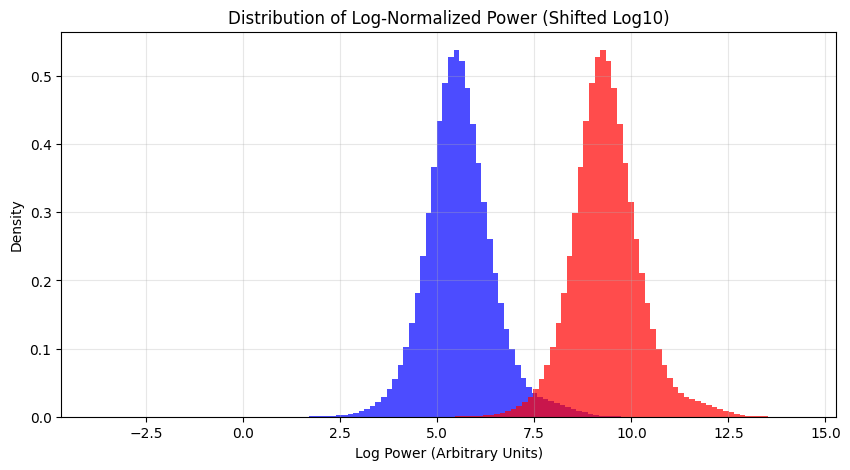

In [ ]:

epsilon = 1e-20
log_Pow_choice = np.log10(Pow_choice + epsilon)

# Shift so the minimum is 0 (optional, but helpful for non-negative decomposition)
# This makes it similar to a dB scale relative to the noise floor
log_Pow_shifted_choice = log_Pow_choice - np.min(log_Pow_choice)

# 2. Plot the Distribution
plt.figure(figsize=(10, 5))
plt.hist(log_Pow_choice.ravel(), bins=100, density=True, color='blue', alpha=0.7)
plt.hist(log_Pow_shifted_choice.ravel(), bins=100, density=True, color='red', alpha=0.7)

plt.title("Distribution of Log-Normalized Power (Shifted Log10)")
plt.xlabel("Log Power (Arbitrary Units)")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.show()



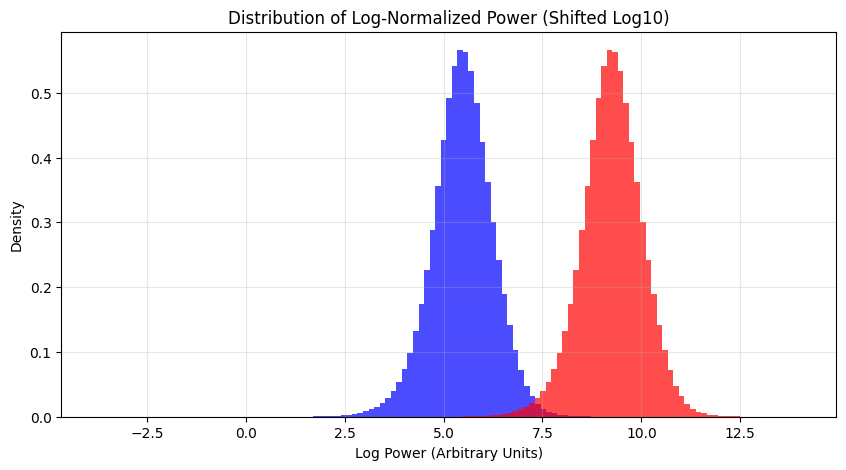

In [ ]:

epsilon = 1e-20
log_Pow_filter_choice = np.log10(Pow_filter_choice + epsilon)

# Shift so the minimum is 0 (optional, but helpful for non-negative decomposition)
# This makes it similar to a dB scale relative to the noise floor
log_Pow_shifted_filter_choice = log_Pow_filter_choice - np.min(log_Pow_filter_choice)

# 2. Plot the Distribution
plt.figure(figsize=(10, 5))
plt.hist(log_Pow_filter_choice.ravel(), bins=100, density=True, color='blue', alpha=0.7)
plt.hist(log_Pow_shifted_filter_choice.ravel(), bins=100, density=True, color='red', alpha=0.7)

plt.title("Distribution of Log-Normalized Power (Shifted Log10)")
plt.xlabel("Log Power (Arbitrary Units)")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.show()



In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
log_Pow_shifted_filtered_torch_choice = torch.as_tensor(power_data_log, device=device, dtype=torch.float32)
log_Pow_shifted_filtered_torch_choice.shape[0]

195

In [36]:
from tensorly.decomposition import non_negative_parafac_hals
import tensorly as tl
tl.set_backend('pytorch')

In [159]:
x = 15


cp_tensor_choice = non_negative_parafac_hals(
                log_Pow_shifted_filtered_torch_choice,
                rank=x,
                init="random",
                n_iter_max=2000,
                tol=1e-8,
                random_state=5  # Ensure different random init
            )

In [38]:
from tensorly.cp_tensor import cp_normalize

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
import torch # Just for the type check

def to_numpy(x):
    """Safely converts PyTorch Tensors to NumPy arrays."""
    if hasattr(x, 'detach'):
        return x.detach().cpu().numpy()
    elif hasattr(x, 'numpy'):
        return x.numpy()
    else:
        return np.array(x)

def plot_factors_on_atlas(A, B, C, D, roi_labels, full_atlas_labels, aal_nifti_path):
    # --- 1. CONVERT INPUTS TO NUMPY ---
    A = to_numpy(A)
    B = to_numpy(B)
    C = to_numpy(C)
    D = to_numpy(D)

    # --- 2. PRE-LOAD ATLAS ---
    aal_img = nib.load(aal_nifti_path)
    aal_data = aal_img.get_fdata()
    affine = aal_img.affine

    R = A.shape[1]

    for r in range(R):
        fig, axes = plt.subplots(1, 4, figsize=(20, 4.5))
        fig.suptitle(f'Component {r+1}', fontsize=16, y=1.05)

        # --- MODE 1: TRIALS ---
        axes[0].bar(range(A.shape[0]), A[:, r], color='tab:blue')
        axes[0].set_title('Trials')
        axes[0].set_ylabel('Loading')
        axes[0].set_xlabel('Trial Number')

        # --- MODE 2: ROIS (SPATIAL) ---
        roi_weights = B[:, r]
        if np.isnan(roi_weights).any():
            roi_weights = np.nan_to_num(roi_weights, nan=0.0)

        brain_vol = np.zeros(aal_data.shape)
        for i, roi_name in enumerate(roi_labels):
            w = roi_weights[i]
            if abs(w) < 1e-10: continue
            try:
                atlas_idx = full_atlas_labels.index(roi_name)
                atlas_id = atlas_idx + 1
                mask = (aal_data == atlas_id)
                brain_vol[mask] = w
            except ValueError:
                pass

        weight_nii = nib.Nifti1Image(brain_vol, affine)

        abs_max = np.max(np.abs(roi_weights))
        thresh = abs_max * 0.8 if abs_max > 0 else 0

        plotting.plot_glass_brain(
            weight_nii,
            axes=axes[1],
            display_mode='ortho', # <--- FIXED: 'lz' was invalid, changed to 'lzr'
            threshold=0.5,
            colorbar=True,
            plot_abs=False
        )
        axes[1].set_title('Spatial (Top/Left/Right)')

        # --- MODE 3: FREQUENCY ---
        freq_axis = np.linspace(0, 70, len(C[:, r]))
        axes[2].plot(freq_axis, C[:, r], color='tab:green', alpha=0.8, linewidth=2)
        axes[2].set_title('Frequency')
        axes[2].set_xlabel('Hz')
        axes[2].grid(True, alpha=0.3)

        # --- MODE 4: TIME ---
        time_axis = np.linspace(0, 1500, len(D[:, r]))
        axes[3].plot(time_axis, D[:, r], color='k', linewidth=1.5)
        axes[3].set_title('Time')
        axes[3].set_xlabel('ms')
        axes[3].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting

def to_numpy(x):
    """Safely converts PyTorch Tensors/Lists to NumPy arrays."""
    if hasattr(x, 'detach'): return x.detach().cpu().numpy()
    elif hasattr(x, 'numpy'): return x.numpy()
    else: return np.array(x)

def filter_top_percent(weights, percentile=90):
    """
    Keeps only the top X% of values (by magnitude). Sets the rest to exactly 0.
    """
    w_abs = np.abs(weights)
    # Calculate the threshold (e.g., 90th percentile)
    threshold = np.percentile(w_abs, percentile)

    # Create a copy and zero out anything below threshold
    filtered = weights.copy()
    filtered[w_abs < threshold] = 0

    return filtered

def plot_factors_on_atlas(A, B, C, D, roi_labels, full_atlas_labels, aal_nifti_path):
    # --- 1. CONVERT INPUTS ---
    A = to_numpy(A)
    B = to_numpy(B)
    C = to_numpy(C)
    D = to_numpy(D)

    # Pre-load Atlas
    aal_img = nib.load(aal_nifti_path)
    aal_data = aal_img.get_fdata()
    affine = aal_img.affine

    R = A.shape[1]

    for r in range(R):
        # ==========================================
        # 1. FILTERING (Top 10%)
        # ==========================================
        raw_weights = B[:, r]

        # Keep only top 10% (90th percentile), set rest to 0
        # These weights retain their original values (no log scaling)
        filtered_weights = filter_top_percent(raw_weights, percentile=90)

        # ==========================================
        # 2. PLOTTING
        # ==========================================
        fig, axes = plt.subplots(1, 4, figsize=(20, 4.5))
        fig.suptitle(f'Component {r+1} (Top 10% Only)', fontsize=16, y=1.05)

        # --- Mode 1: Trials ---
        axes[0].bar(range(A.shape[0]), A[:, r], color='tab:blue')
        axes[0].set_title('Trials')
        axes[0].set_ylabel('Loading')
        axes[0].set_xlabel('Trial Number')

        # --- Mode 2: ROIs ---
        brain_vol = np.zeros(aal_data.shape)

        for i, roi_name in enumerate(roi_labels):
            w = filtered_weights[i]

            # Skip exact zeros (the 90% we filtered out)
            if w == 0: continue

            try:
                atlas_idx = full_atlas_labels.index(roi_name)
                atlas_id = atlas_idx + 1
                mask = (aal_data == atlas_id)
                brain_vol[mask] = w
            except ValueError:
                pass

        weight_nii = nib.Nifti1Image(brain_vol, affine)

        # Determine a nice max value for the colorbar based on the data
        # We look at the max absolute value of the *filtered* data
        max_val = np.max(np.abs(filtered_weights))
        if max_val == 0: max_val = 1 # Safety for empty components

        plotting.plot_glass_brain(
            weight_nii,
            axes=axes[1],
            display_mode='ortho',
            colorbar=True,
            plot_abs=False,
            # We set threshold slightly above 0 to make the background transparent
            threshold=1e-10,
            # Optional: Symmetrize the colorbar around 0
            vmin=-max_val,
            vmax=max_val,
               # Red-Blue is standard for raw signed weights
        )
        axes[1].set_title('Spatial (Raw Top 10%)')

        # --- Mode 3: Freq ---
        freq_axis = np.linspace(0, 70, len(C[:, r]))
        axes[2].plot(freq_axis, C[:, r], color='tab:green', alpha=0.8, linewidth=2)
        axes[2].set_title('Frequency')
        axes[2].set_xlabel('Hz')
        axes[2].grid(True, alpha=0.3)

        # --- Mode 4: Time ---
        time_axis = np.linspace(0, 1500, len(D[:, r]))
        axes[3].plot(time_axis, D[:, r], color='k', linewidth=1.5)
        axes[3].set_title('Time')
        axes[3].set_xlabel('ms')
        axes[3].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

In [160]:
weights,  factors = cp_tensor_choice
A,B,C,D = factors

In [145]:
cp_tensor_norm = cp_normalize(cp_tensor_choice)

In [146]:
weights,  factors = cp_tensor_norm
A,B,C,D = factors

/tmp/ipython-input-1026798832.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


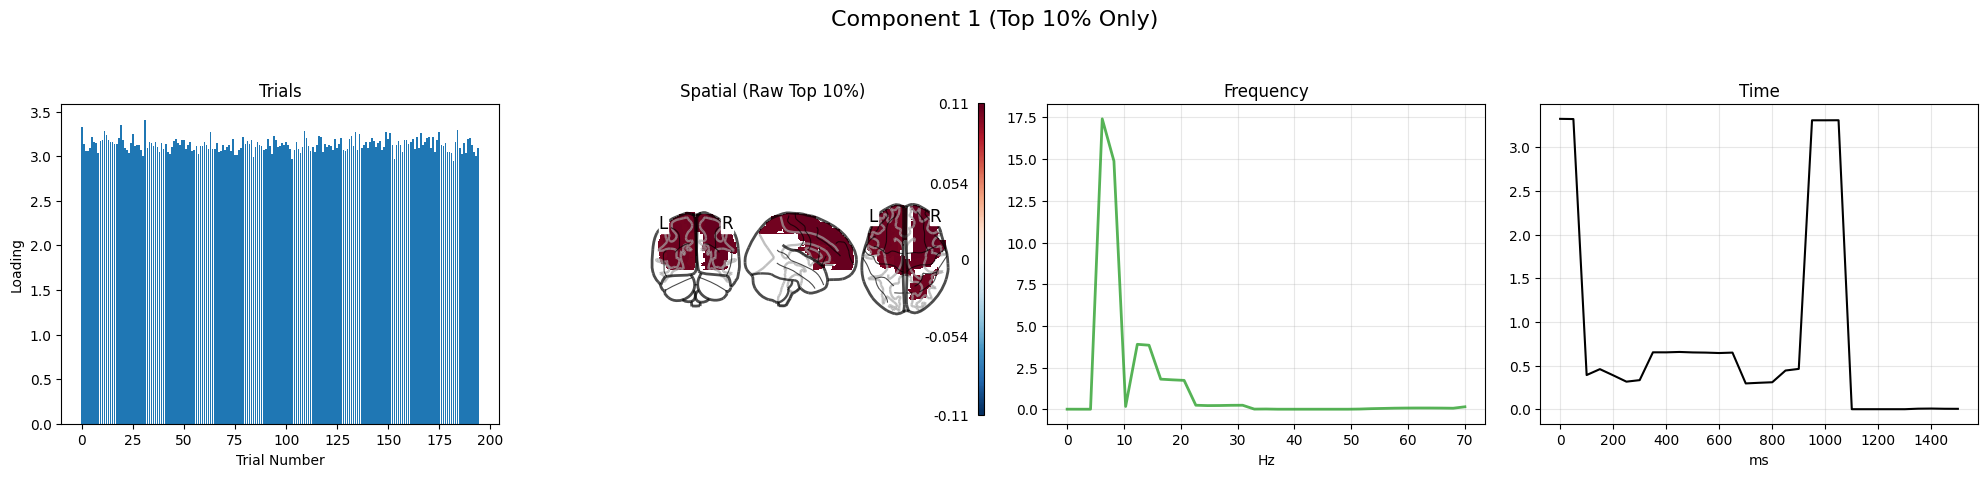

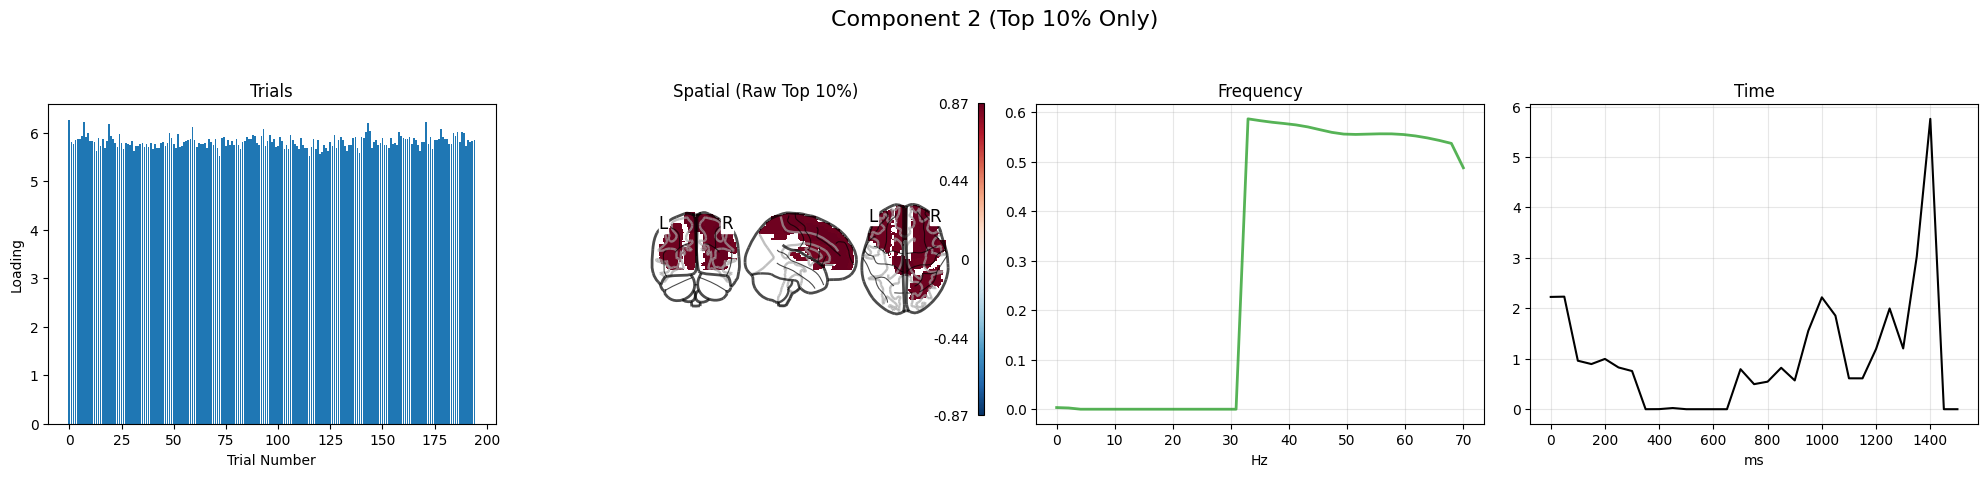

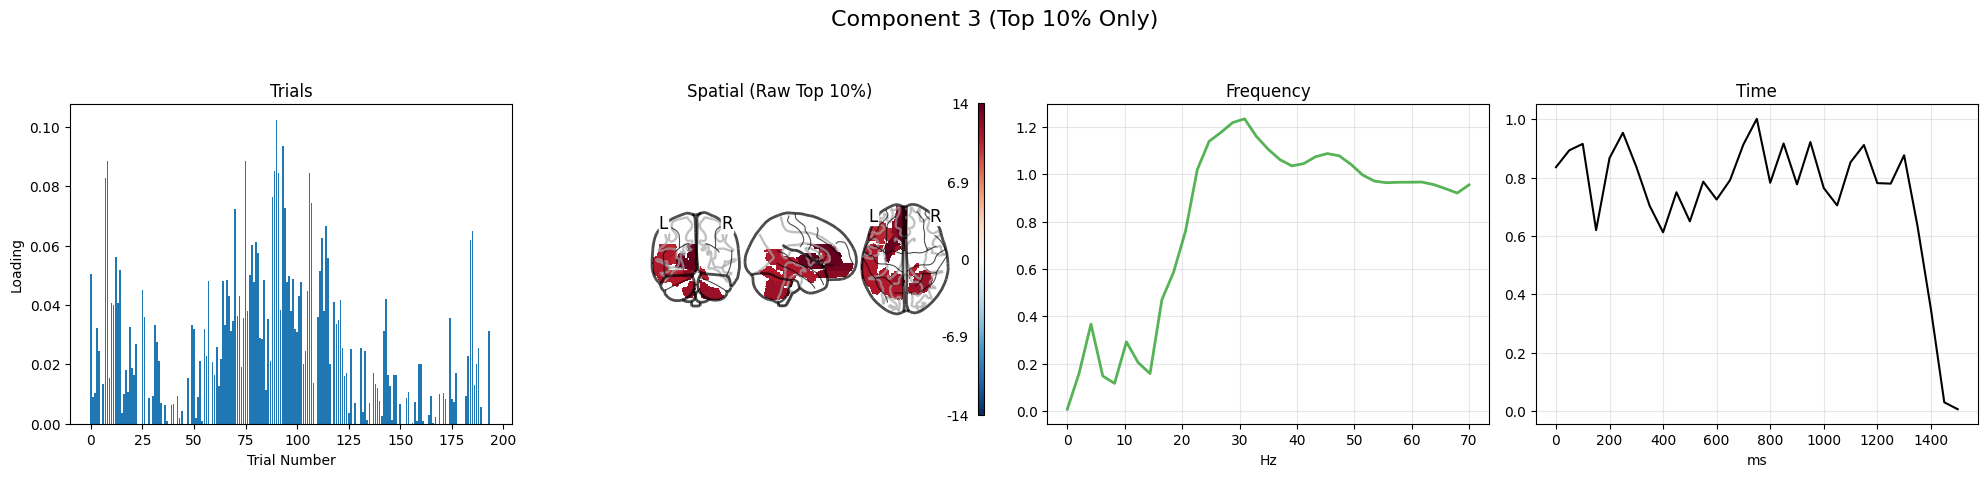

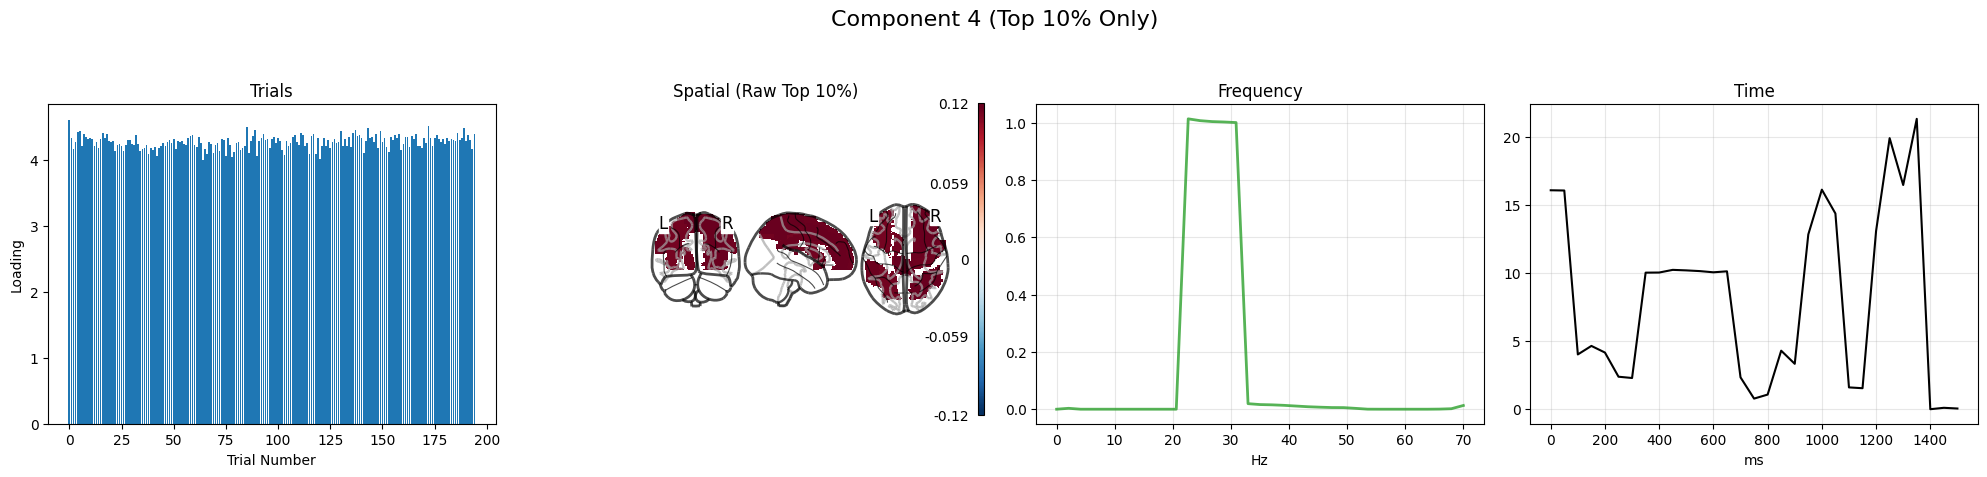

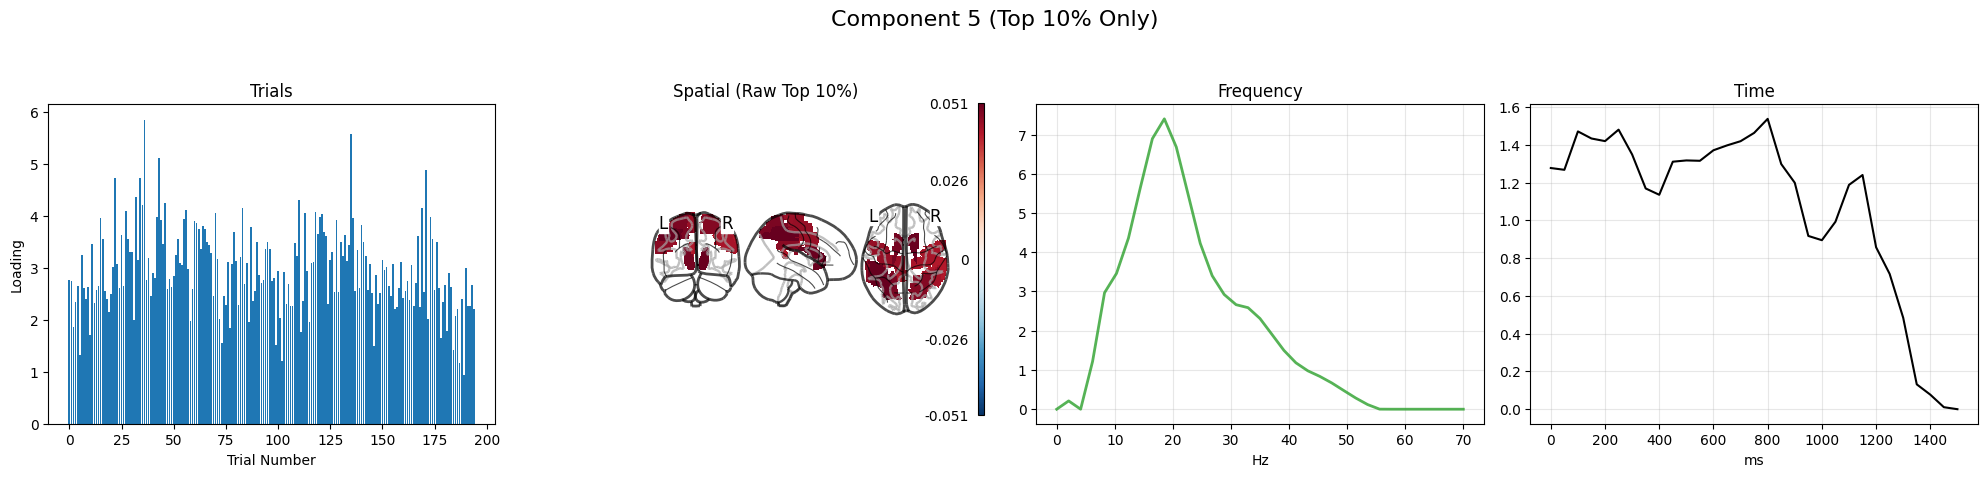

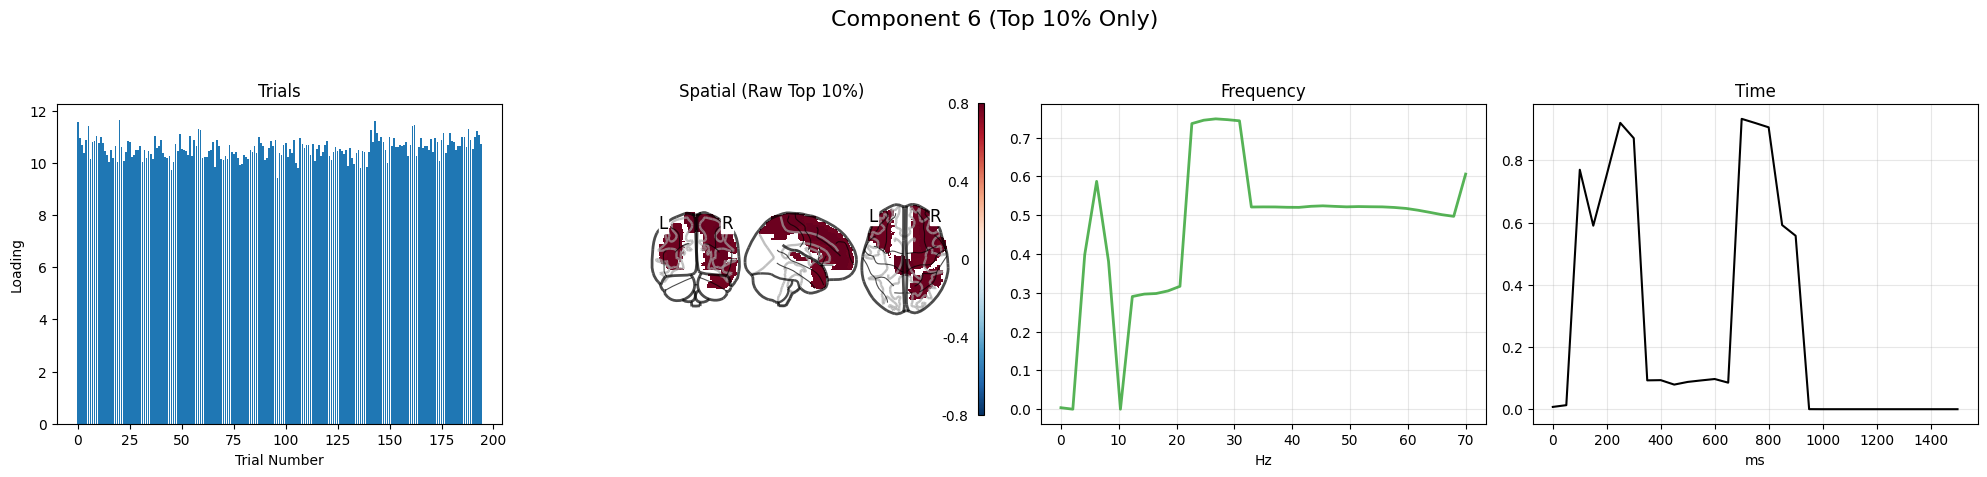

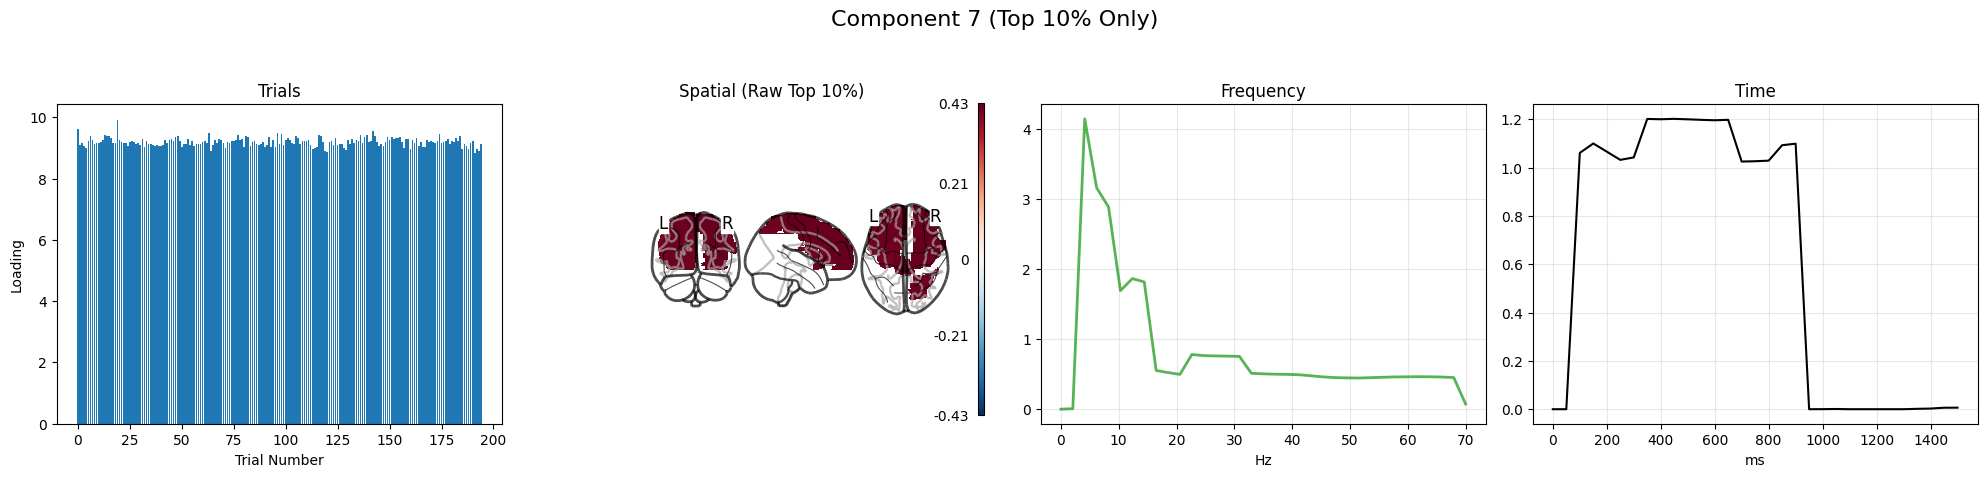

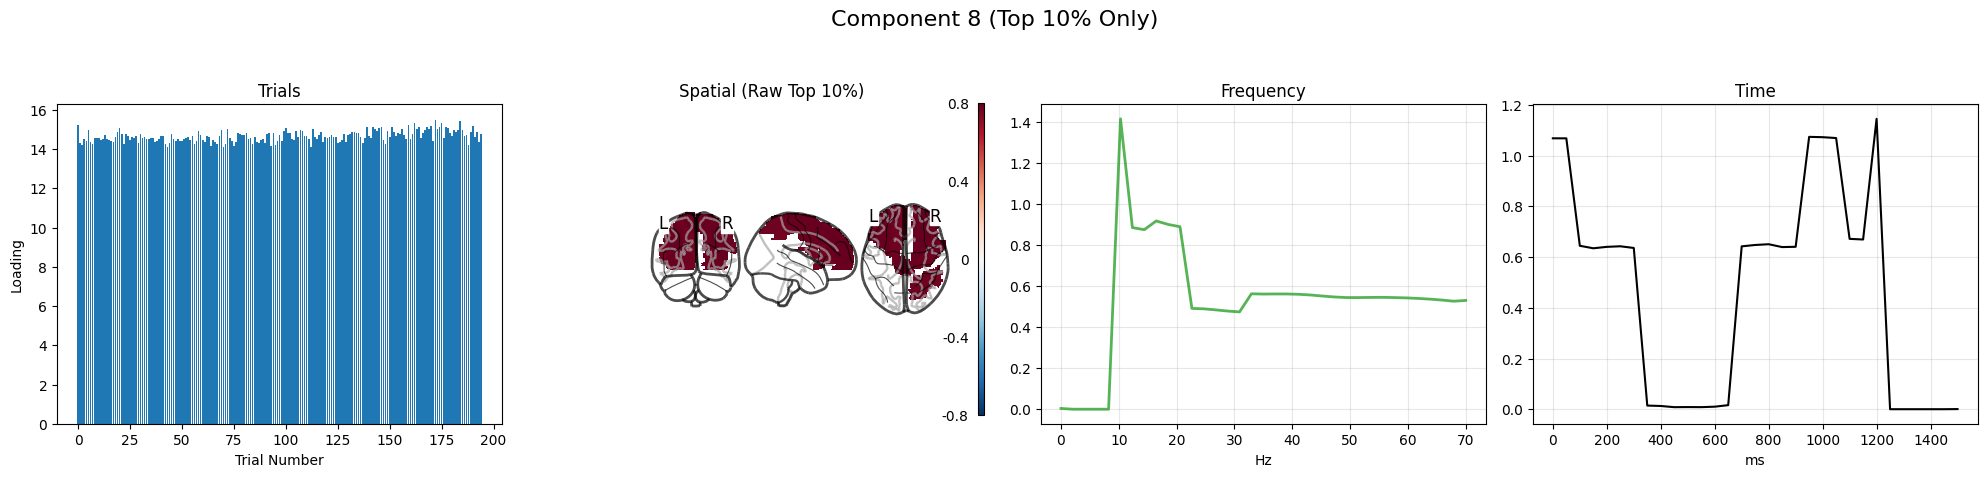

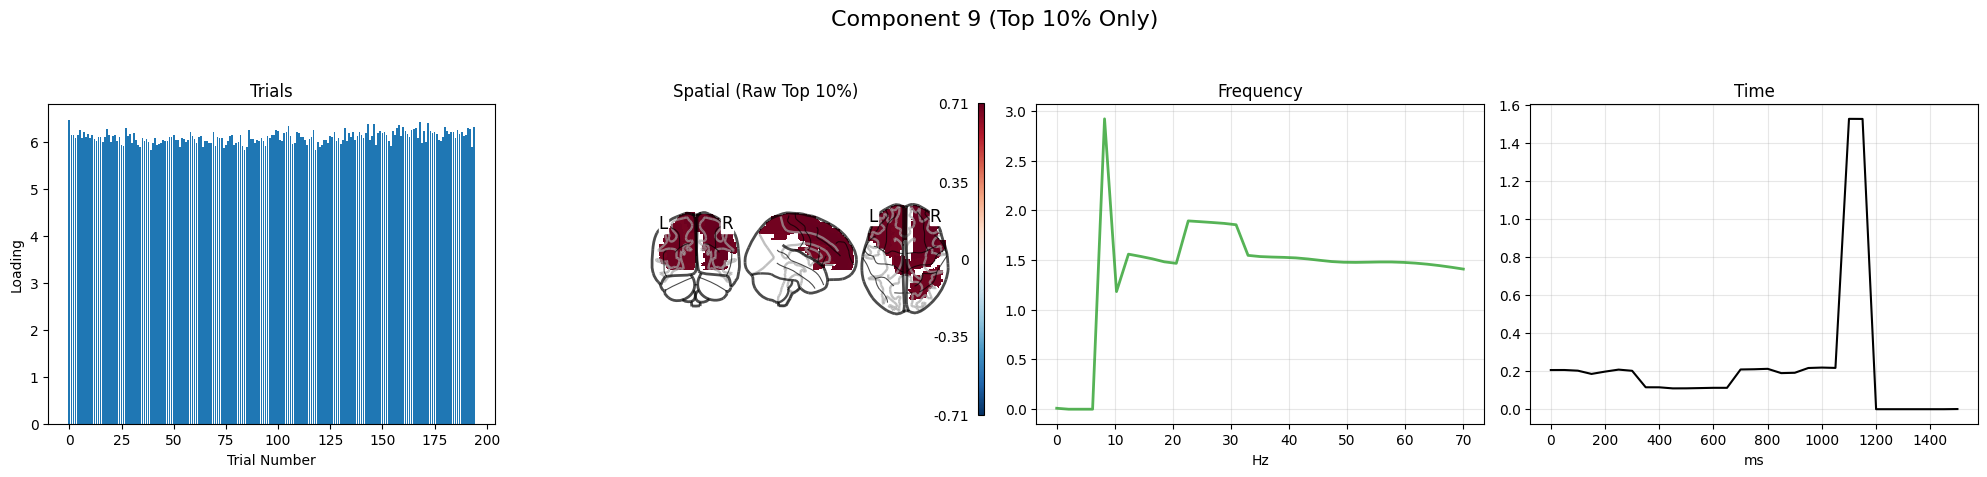

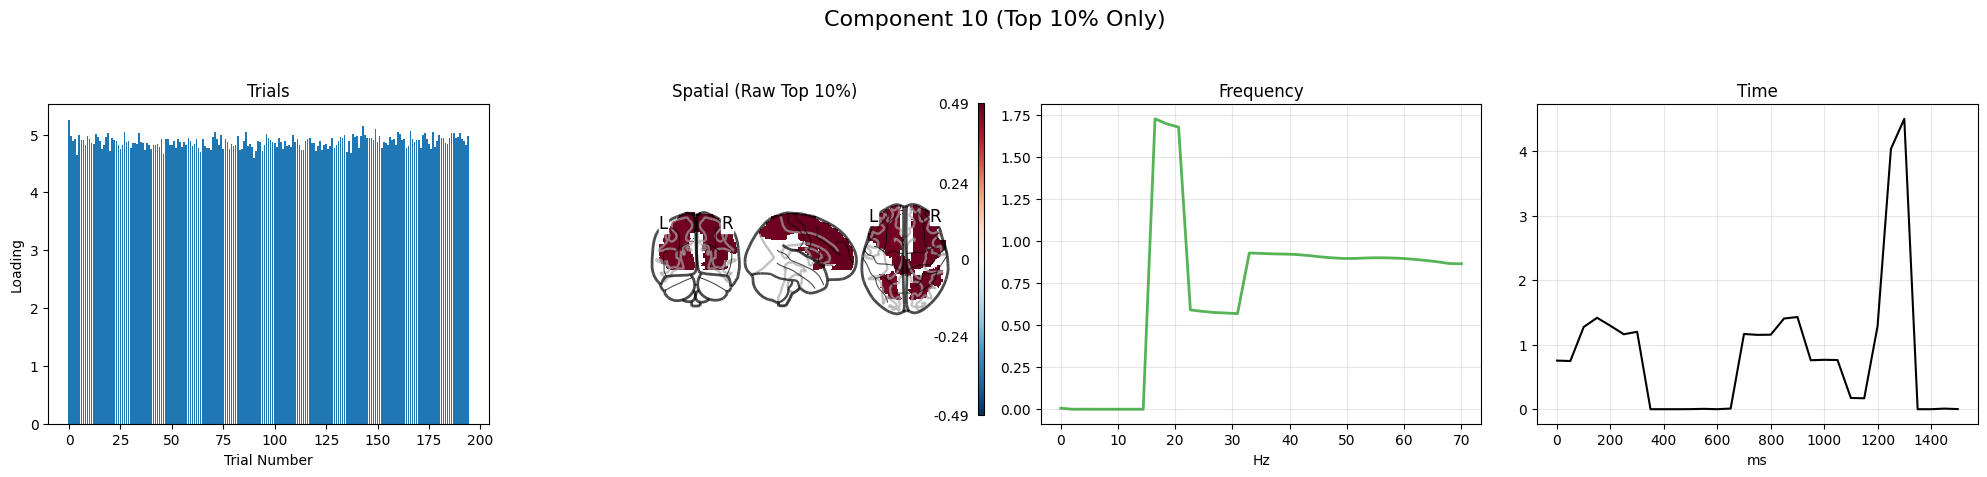

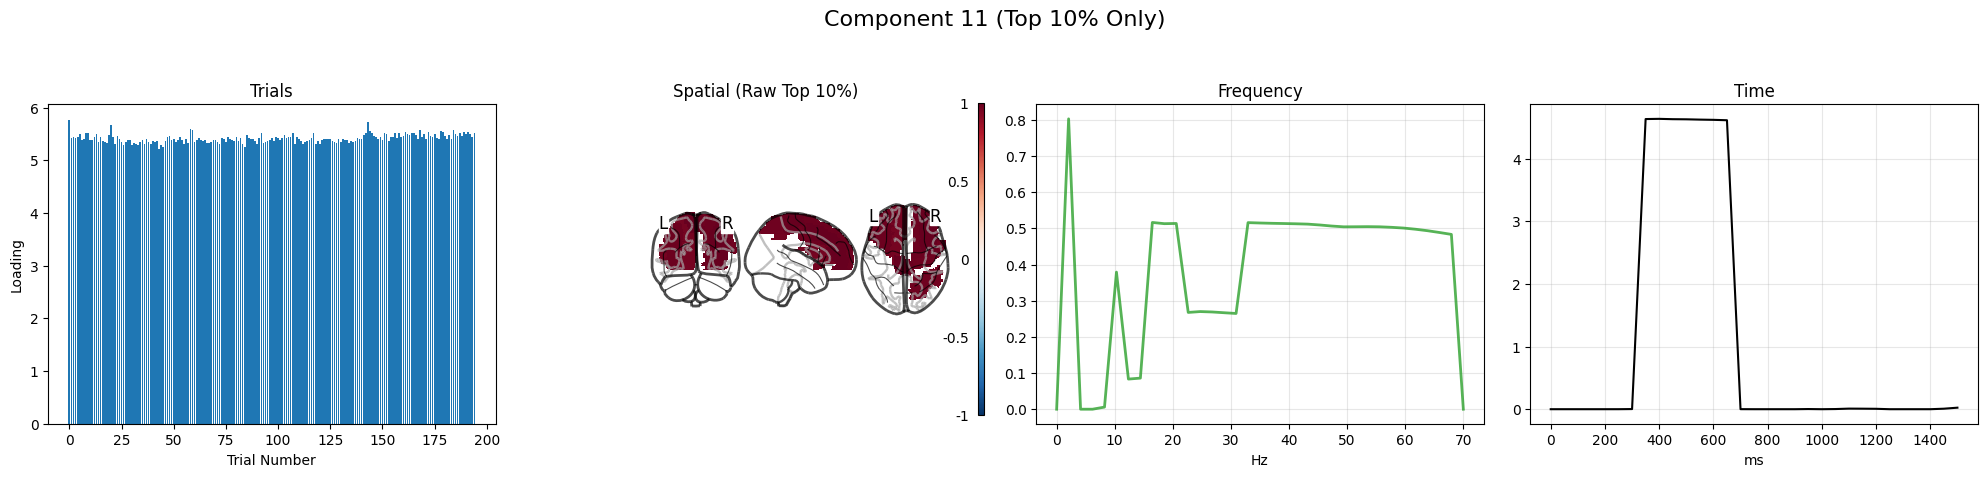

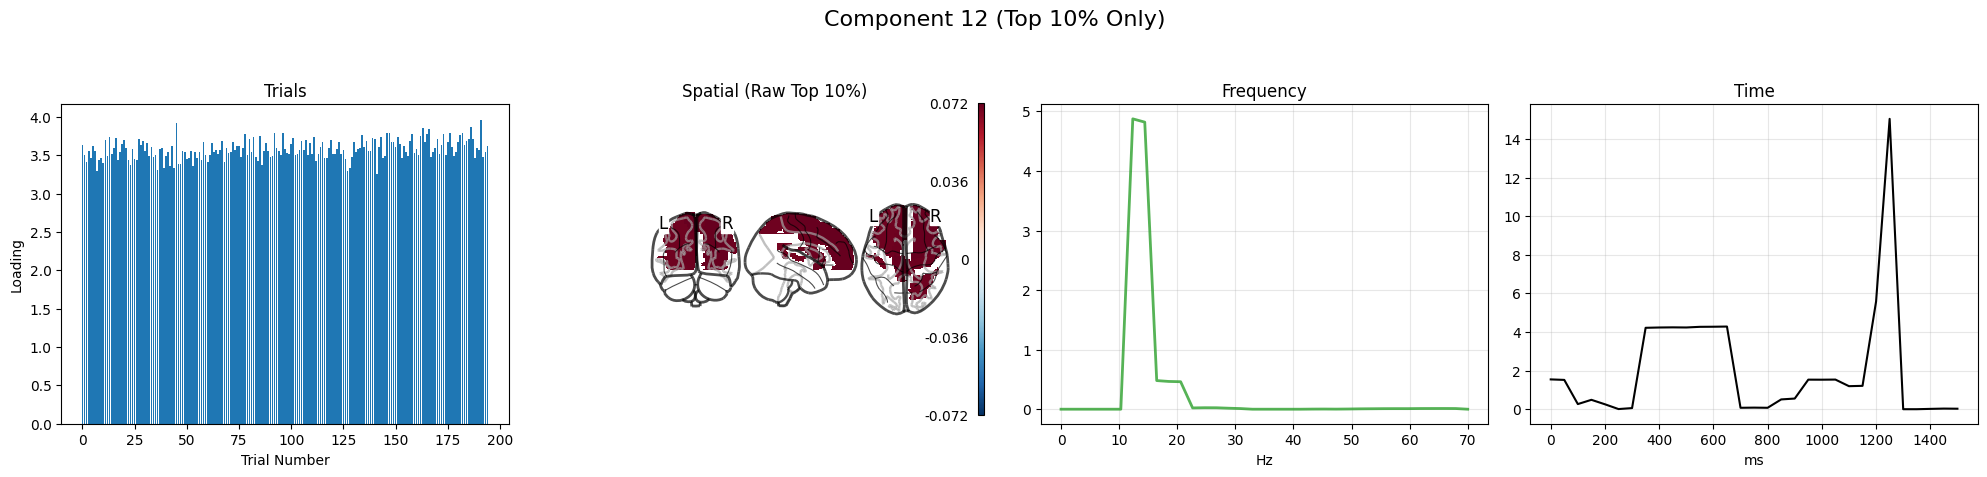

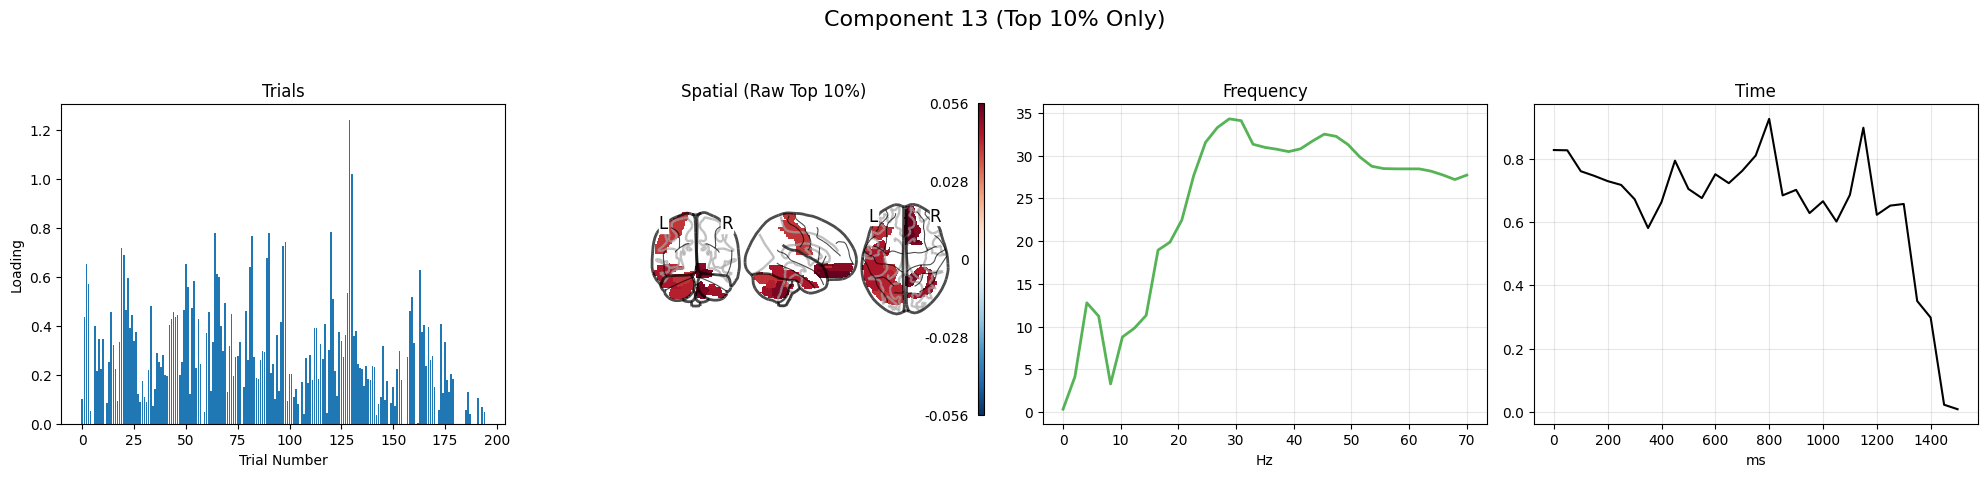

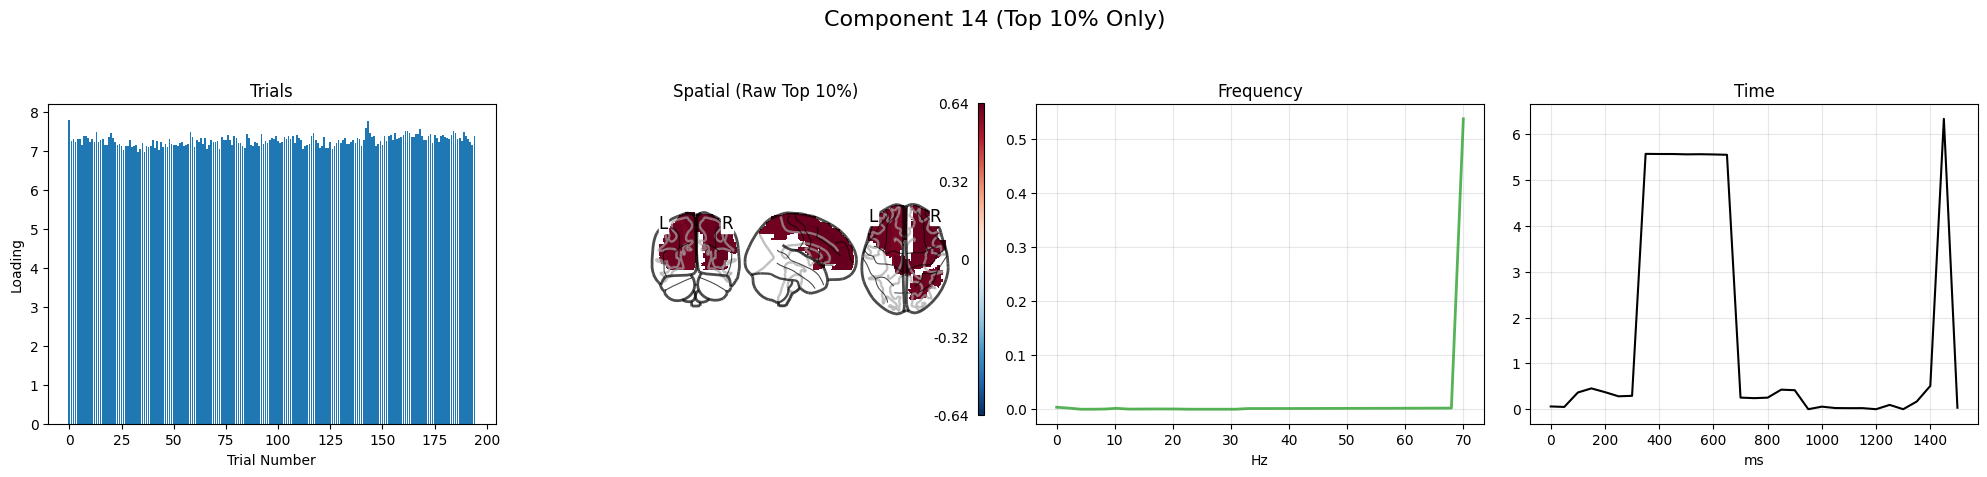

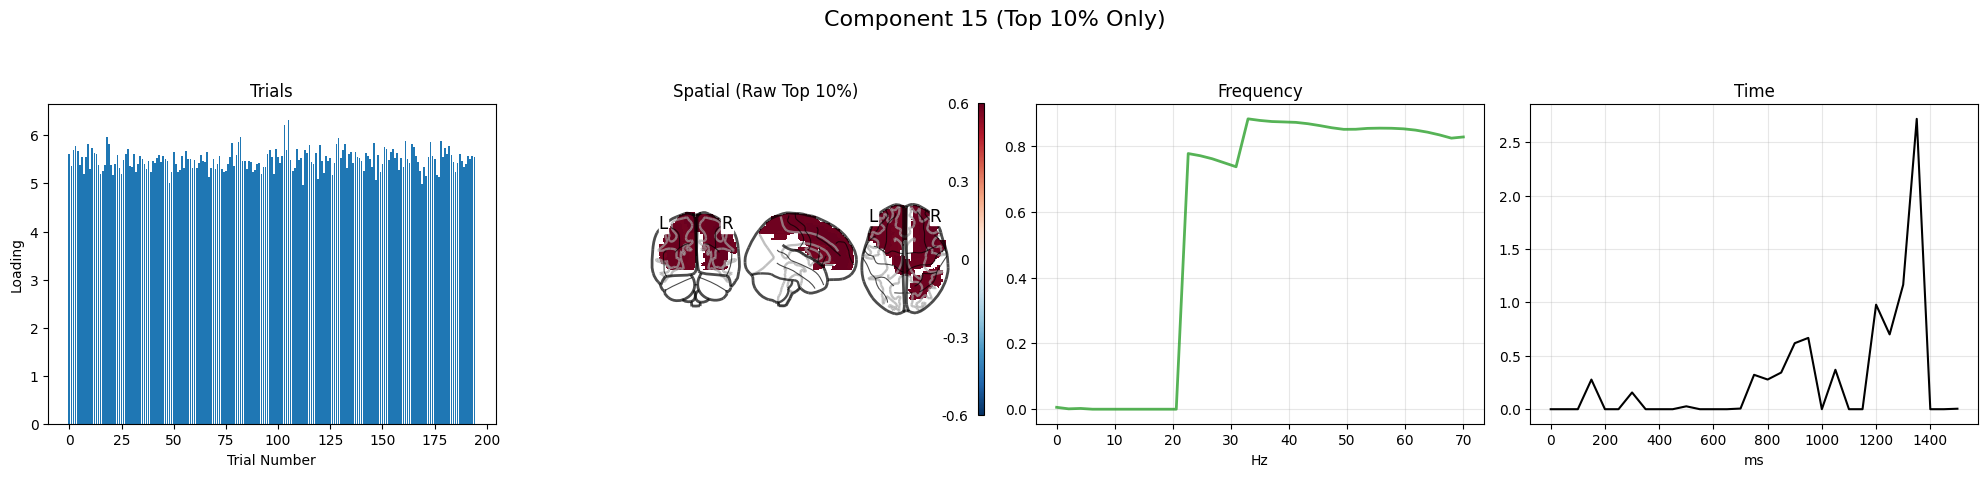

In [161]:
plot_factors_on_atlas(A,B,C,D,roi_labels, full_atlas_labels, ATLAS_NII_PATH)

In [76]:
import numpy as np
import torch

def to_numpy(x):
    """Safely converts PyTorch Tensors to NumPy arrays."""
    if hasattr(x, 'detach'):
        return x.detach().cpu().numpy()
    elif hasattr(x, 'numpy'):
        return x.numpy()
    else:
        return np.array(x)

def print_top_rois(B, roi_labels, n_top=10):
    """
    Prints the top N most activated ROIs for each component in factor matrix B.

    Parameters
    ----------
    B : np.ndarray or torch.Tensor
        Factor matrix for the spatial mode (Shape: [n_ROIs, n_Components]).
    roi_labels : list of str
        Names of the ROIs corresponding to the rows of B.
    n_top : int
        Number of top regions to display (default: 10).
    """

    # 1. Ensure B is a numpy array
    B = to_numpy(B)

    n_rois, n_components = B.shape

    # 2. Loop through each component
    for r in range(n_components):
        print(f"\n" + "="*50)
        print(f" COMPONENT {r+1}: TOP {n_top} REGIONS")
        print("="*50)
        print(f"{'Rank':<5} | {'ROI Name':<30} | {'Weight':>10}")
        print("-" * 50)

        # 3. Extract weights for this component
        weights = B[:, r]

        # 4. Get indices of the largest values (by Absolute Magnitude)
        # argsort sorts ascending, so we take the end and reverse it
        top_indices = np.argsort(np.abs(weights))[-n_top:][::-1]

        # 5. Print rows
        for rank, idx in enumerate(top_indices):
            if idx < len(roi_labels):
                name = roi_labels[idx]
                val  = weights[idx]
                print(f"{rank+1:<5} | {name:<30} | {val:10.4f}")
            else:
                print(f"{rank+1:<5} | {'(Index Error)':<30} | {0.0000}")

        print("-" * 50)

# --- EXAMPLE USAGE ---
#

In [135]:
print_top_rois(B, roi_labels, n_top=10)


 COMPONENT 1: TOP 10 REGIONS
Rank  | ROI Name                       |     Weight
--------------------------------------------------
1     | tissue 6                       |     0.6774
2     | tissue 73                      |     0.6683
3     | tissue 74                      |     0.6612
4     | tissue 4                       |     0.6605
5     | tissue 5                       |     0.6603
6     | tissue 9                       |     0.6515
7     | tissue 66                      |     0.6507
8     | tissue 64                      |     0.6471
9     | tissue 19                      |     0.6466
10    | tissue 2                       |     0.6460
--------------------------------------------------

 COMPONENT 2: TOP 10 REGIONS
Rank  | ROI Name                       |     Weight
--------------------------------------------------
1     | tissue 6                       |     0.6963
2     | tissue 73                      |     0.6883
3     | tissue 74                      |     0.6819
4     |

In [153]:
pp = B[:,1].to('cpu').numpy()

In [154]:
pp.shape

(117,)

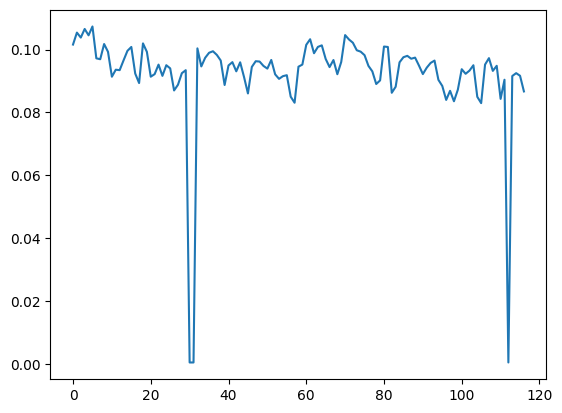

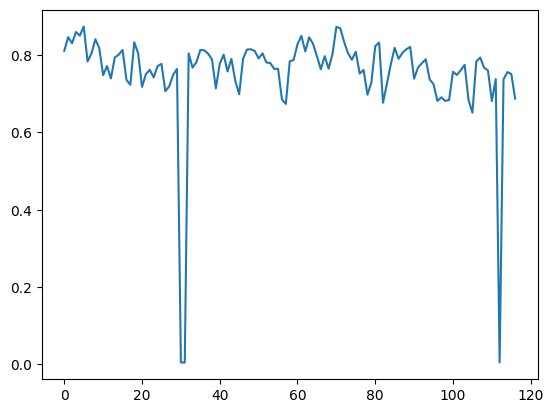

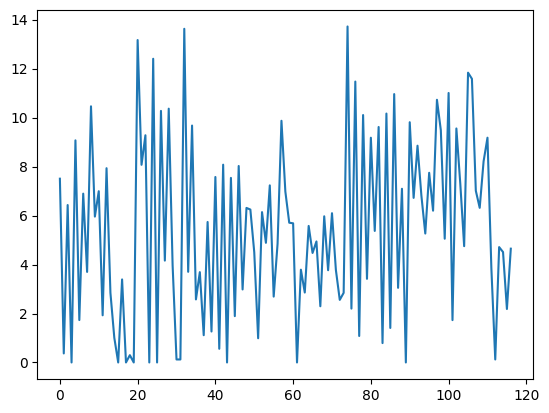

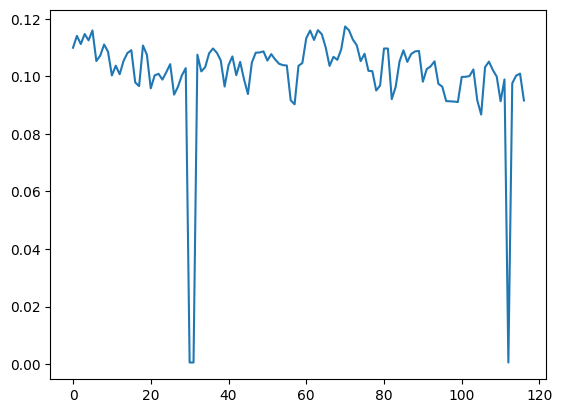

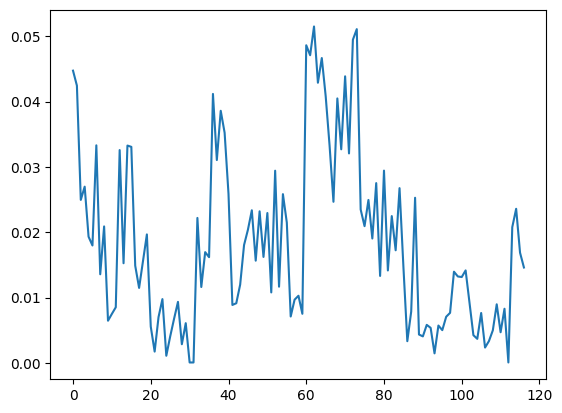

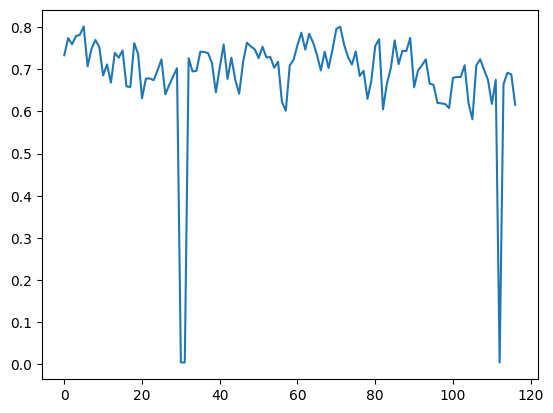

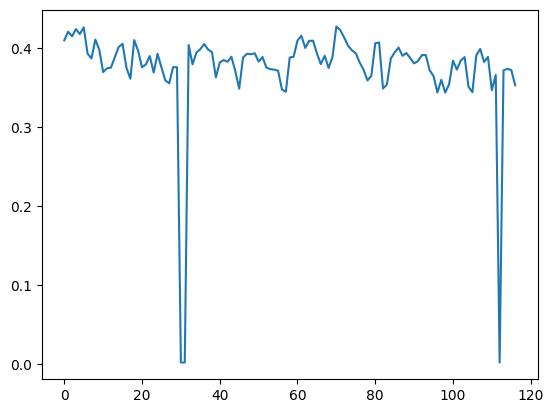

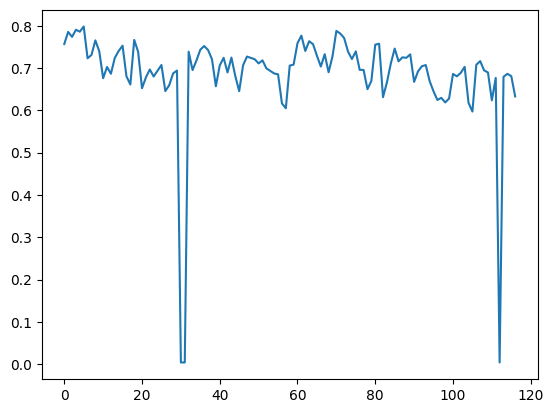

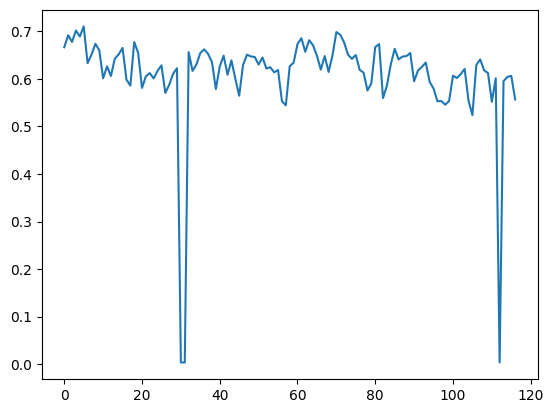

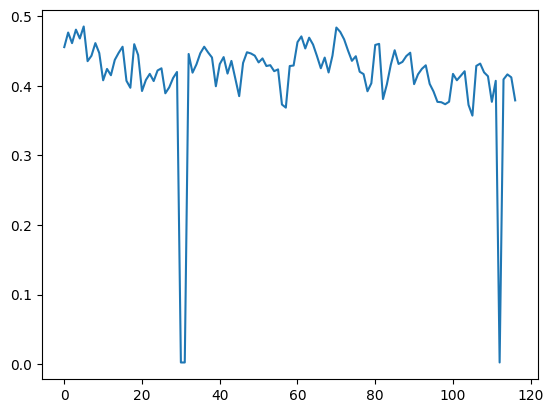

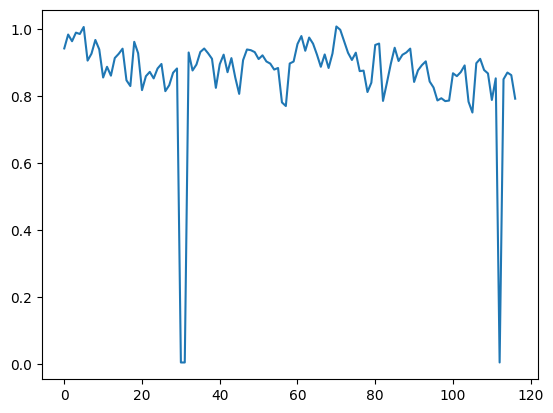

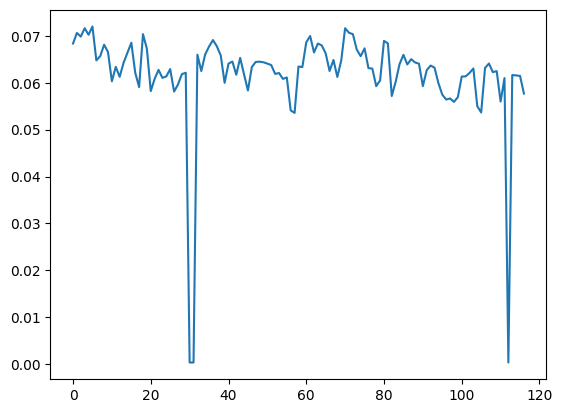

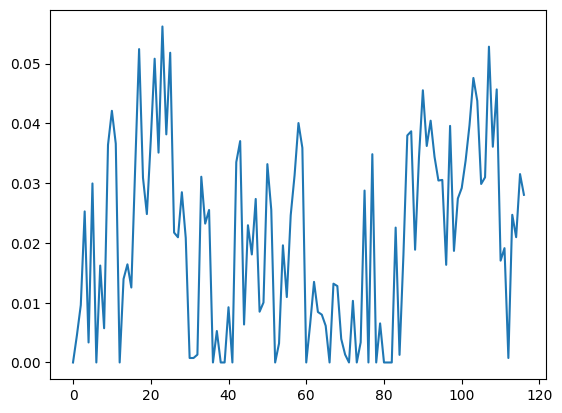

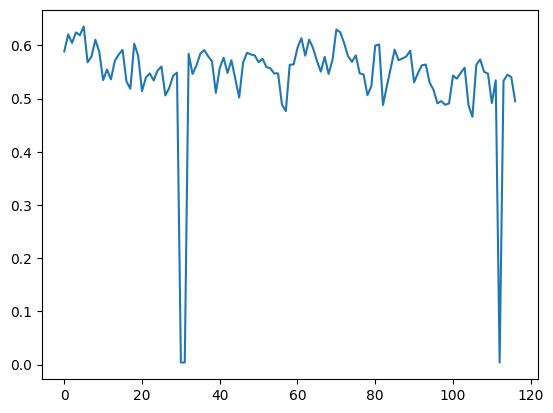

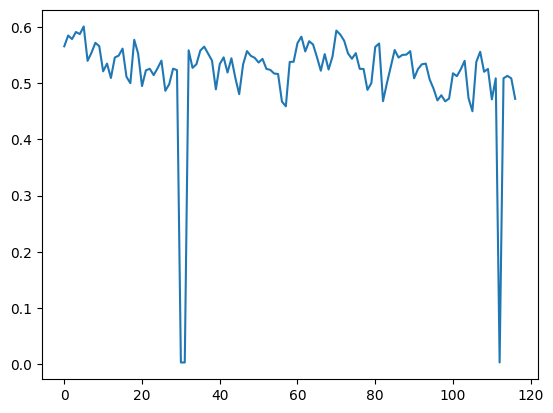

In [163]:
for r in range(B.shape[1]):
  plt.figure()
  plt.plot(B[:,r].to('cpu').numpy())